In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Para formatação dos eixos, se necessário

# Exemplo de valores (pode ser substituído por input do usuário)
f_str_exemplo = str('2*x*y') # Mesma EDO dos exemplos anteriores para consistência
x_exemplo = 1
y_exemplo = 2
h_exemplo = 0.1
interacoes_exemplo = 27


In [2]:

def resolver_edo_rk3(f_str, x_inicial, y_inicial, h_passo, num_total_iteracoes):
    """
    Resolve uma EDO de primeira ordem dy/dx = f(x,y) usando o método de Runge-Kutta de 3ª Ordem.

    Fórmulas:
        y_{i+1} = y_i + (k_1 + 4*k_2 + k_3)*h/6
        k_1 = f(x_i, y_i)
        k_2 = f(x_i + h/2, y_i + k_1*h/2)
        k_3 = f(x_i + h, y_i - k_1*h + 2*k_2*h)

    Args:
        f_str (str): A equação dy/dx = f(x,y) como string.
        x_inicial (float/int): Valor inicial de x (x0).
        y_inicial (float/int): Valor inicial de y (y0).
        h_passo (float/int): Tamanho do passo (h).
        num_total_iteracoes (int): Número de iterações a serem calculadas APÓS o ponto inicial.

    Returns:
        tuple: Contendo:
            - df (pd.DataFrame): DataFrame com os resultados das iterações.
            - equacao_info (str): String descrevendo a equação fornecida.
            - condicoes_info (str): String descrevendo as condições iniciais.
            - passo_info (str): String descrevendo o passo h.
            - num_iteracoes_info (str): String descrevendo o número de iterações.
        Retorna (None, error_message, None, None, None) em caso de erro na conversão
        de input ou na interpretação da função.
    """

    try:
        x0_global = float(x_inicial)
        y0_global = float(y_inicial)
        h = float(h_passo)
        num_iteracoes = int(num_total_iteracoes)
    except ValueError:
        error_msg = "Erro: Entrada inválida. Certifique-se de que os valores numéricos (x_inicial, y_inicial, h_passo, num_total_iteracoes) estão corretos."
        return None, error_msg, None, None, None

    try:
        allowed_names = {"x": None, "y": None, "math": math}
        def func(x_eval, y_eval):
            return eval(f_str, {"__builtins__": {}}, {**allowed_names, "x": x_eval, "y": y_eval})
        func(x0_global, y0_global) # Teste inicial
    except Exception as e:
        error_msg = f"Erro ao interpretar a função f(x,y) ('{f_str}'): {e}\n" \
            "Certifique-se de que a equação usa 'x' e 'y' como variáveis.\n" \
            "Para funções matemáticas, use o prefixo 'math.', por exemplo, 'math.sin(x)'."
        return None, error_msg, None, None, None

    equacao_info = f"Equação fornecida: dy/dx = {f_str}"
    condicoes_info = f"Condições iniciais: x0 = {x0_global}, y0 = {y0_global}"
    passo_info = f"Passo (h): {h}"
    num_iteracoes_info = f"Número de iterações após o ponto inicial: {num_iteracoes}"

    iter_col = []
    x_col = []
    y_col = []
    k1_col = []
    k2_col = []
    k3_col = [] # Nova coluna para RK3
    erro_col = []

    x_i = x0_global
    y_i = y0_global

    # Iteração 0 (ponto inicial)
    iter_col.append(0)
    x_col.append(x_i)
    y_col.append(y_i)

    # k1, k2, k3 são calculados para o ponto (x_i, y_i) atual
    # Estes k's da linha 'Iter. i' serão usados para calcular y na linha 'Iter. i+1'
    k1_atual = func(x_i, y_i)
    k1_col.append(k1_atual)

    k2_atual = func(x_i + h / 2.0, y_i + k1_atual * h / 2.0)
    k2_col.append(k2_atual)

    k3_atual = func(x_i + h, y_i - k1_atual * h + 2.0 * k2_atual * h)
    k3_col.append(k3_atual)
    erro_col.append(float('nan'))

    # Loop para as iterações seguintes
    for i in range(1, num_iteracoes + 1):
        y_anterior_neste_passo = y_i # y_i da iteração anterior (y_{n-1})
        
        # k1, k2, k3 da iteração anterior
        k1_do_passo_anterior = k1_atual 
        k2_do_passo_anterior = k2_atual
        k3_do_passo_anterior = k3_atual

        # Fórmula de RK3 para y_{i+1}
        y_i = y_i + (k1_do_passo_anterior + 4.0 * k2_do_passo_anterior + k3_do_passo_anterior) * h / 6.0

        x_i = x0_global + i * h

        iter_col.append(i)
        x_col.append(x_i)
        y_col.append(y_i)

        # Calcula k1, k2, k3 para ESTA iteração (x_i, y_i atuais)
        k1_atual = func(x_i, y_i)
        k1_col.append(k1_atual)

        k2_atual = func(x_i + h / 2.0, y_i + k1_atual * h / 2.0)
        k2_col.append(k2_atual)

        k3_atual = func(x_i + h, y_i - k1_atual * h + 2.0 * k2_atual * h)
        k3_col.append(k3_atual)

        erro_val = abs(y_i - y_anterior_neste_passo)
        erro_col.append(erro_val)

    df = pd.DataFrame({
        'Iter.': iter_col,
        'x0': x_col,
        'y0': y_col,
        'K1': k1_col,
        'K2': k2_col,
        'K3': k3_col, # Adicionando K3 ao DataFrame
        'ERRO |yn-yn-1|': erro_col
    })

    return df, equacao_info, condicoes_info, passo_info, num_iteracoes_info


def gerar_grafico_edo_rk3(df_resultados, titulo_grafico="Solução da EDO pelo Método de Runge-Kutta 3ª Ordem"):
    """
    Gera e exibe um gráfico da solução da EDO (y0 vs x0) e do erro
    (|yn - y_{n-1}| vs x0) a partir de um DataFrame para o método RK3.
    """
    if not isinstance(df_resultados, pd.DataFrame):
        print("Erro: A entrada deve ser um DataFrame do Pandas.")
        return
    required_cols = {'x0', 'y0', 'ERRO |yn-yn-1|'} # K3 não é plotado diretamente no gráfico principal
    if not required_cols.issubset(df_resultados.columns):
        print(f"Erro: O DataFrame deve conter as colunas {required_cols}.")
        return
    if df_resultados.empty:
        print("Erro: O DataFrame está vazio, nada para plotar.")
        return

    plt.figure(figsize=(12, 7))
    plt.plot(df_resultados['x0'], df_resultados['y0'], marker='o',
             linestyle='-', color='forestgreen', label='$y_n$ (Solução RK3)') # Cor diferente
    plt.plot(df_resultados['x0'], df_resultados['ERRO |yn-yn-1|'], marker='s',
             linestyle='--', color='crimson', label='$|y_n - y_{n-1}|$ (Erro Aproximado)') # Cor diferente

    plt.title(titulo_grafico, fontsize=16)
    plt.xlabel("$x_n$", fontsize=14)
    plt.ylabel("Valores", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    return plt


In [3]:

# --- Exemplo de uso do método de Runge-Kutta de 3ª Ordem ---
dataframe_rk3, eq_info_rk3, ci_info_rk3, p_info_rk3, ni_info_rk3 = resolver_edo_rk3(
    f_str_exemplo,
    x_exemplo,
    y_exemplo,
    h_exemplo,
    interacoes_exemplo
)

Solução de EDO pelo Método de Runge-Kutta de 3ª Ordem
----------------------------------------------------
Equação fornecida: dy/dx = 2*x*y
Condições iniciais: x0 = 1.0, y0 = 2.0
Passo (h): 0.1
Número de iterações após o ponto inicial: 27
----------------------------------------------------

Resultados das Iterações:
 Iter.    x0          y0           K1           K2            K3 ERRO |yn-yn-1|
     0 1.000      2.0000       4.0000       4.6200        5.5528            NaN
     1 1.100      2.4672       5.4279       6.2988        7.6420         0.4672
     2 1.200      3.1050       7.4519       8.6939       10.6562         0.6378
     3 1.300      3.9864      10.3645      12.1624       15.0707         0.8814
     4 1.400      5.2211      14.6191      17.2610       21.6342         1.2347
     5 1.500      6.9761      20.9282      24.8697       31.5430         1.7550
     6 1.600      9.5086      30.4274      36.3988       46.7349         2.5325
     7 1.700     13.2212      44.9520    

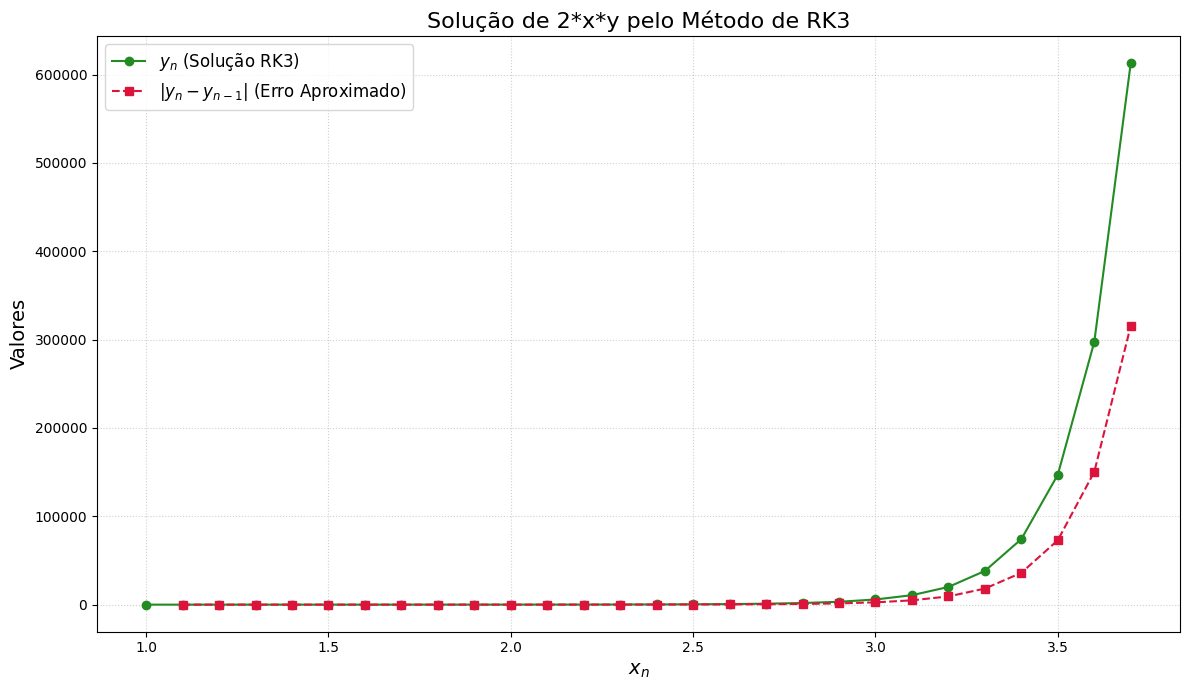

In [4]:

if dataframe_rk3 is not None:
    print("Solução de EDO pelo Método de Runge-Kutta de 3ª Ordem")
    print("----------------------------------------------------")
    print(eq_info_rk3)
    print(ci_info_rk3)
    print(p_info_rk3)
    print(ni_info_rk3)
    print("----------------------------------------------------\n")
    print("Resultados das Iterações:")

    # Formatação para o DataFrame de RK3, baseado na imagem:
    # x0: 3 casas (1.000)
    # y0: 4 casas (2.4672)
    # K1, K2, K3: 4 casas
    # ERRO: 4 casas
    formatters_rk3 = {
        'x0': '{:.3f}'.format,
        'y0': '{:.4f}'.format,
        'K1': '{:.4f}'.format,
        'K2': '{:.4f}'.format,
        'K3': '{:.4f}'.format,
        'ERRO |yn-yn-1|': '{:.4f}'.format
    }
    print(dataframe_rk3.to_string(index=False, na_rep='NaN', formatters=formatters_rk3))

    grafico_rk3 = gerar_grafico_edo_rk3(
        dataframe_rk3, titulo_grafico=f"Solução de {f_str_exemplo} pelo Método de RK3"
    )
    # grafico_rk3.show() # Descomente para exibir o gráfico
    print("\nGráfico gerado (descomente plt.show() na função ou aqui para exibir).")

else:
    print(f"Não foi possível calcular a solução: {eq_info_rk3}")


In [5]:
dataframe_rk3

,Iter.,x0,y0,K1,K2,K3,ERRO |yn-yn-1|
0,0,1.0,2.000000,4.000000e+00,4.620000e+00,5.552800e+00,NaN
1,1,1.1,2.467213,5.427869e+00,6.298796e+00,7.642045e+00,0.467213
2,2,1.2,3.104965,7.451916e+00,8.693902e+00,1.065624e+01,0.637752
3,3,1.3,3.986361,1.036454e+01,1.216239e+01,1.507068e+01,0.881396
4,4,1.4,5.221107,1.461910e+01,1.726098e+01,2.163418e+01,1.234746
5,5,1.5,6.976060,2.092818e+01,2.486966e+01,3.154295e+01,1.754953
6,6,1.6,9.508556,3.042738e+01,3.639875e+01,4.673493e+01,2.532496
7,7,1.7,13.221179,4.495201e+01,5.414073e+01,7.039484e+01,3.712622
8,8,1.8,18.753008,6.751083e+01,8.187563e+01,1.078328e+02,5.531829
9,9,1.9,27.133777,1.031084e+02,1.259279e+02,1.680341e+02,8.380769
